# PA005 - High Value Customer Indetification

## 0.0. Planejamento da Solução

### Input - Entrada

1. Problema de Negócio
    - Selecionar os clientes mais valiosos para integrar um programa de Fidelização.
    
2. Conjunto de Dados
    - Vendas em um e-commerce online, durante o periodo de um ano.

### Output - Saida

1. Indicação das pessoas que farão parte do programa de Insiders
    - Lista: 
            client_id | is_insider |
              1023     |     Yes  |
              
2. Relatório com as perguntas de negócio:
    - Quem são as pessoas elegiveis para participar do programa de Insiders?
    - Quantos clientes farão parte do grupo?
    - Quais as principais caracteristicas dos clientes?
    - Qual a porcentagem de contribuição do faturamento vinda dos Insiders?
    - Qual a expectativa de faturamento desse grupo para os próximos meses?
    - Quais as condições para uma pessoa ser elegivel aos Insiders?
    - Quais as condições para uma pessoa ser removida dos Insiders? 
    - Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks

1. Quem são as pessoas elegiveis para participar do programa de Insiders?
    - O que é ser elegivel? 
    
    - O que são clientes de maior valor?
        - Faturamento: Alto ticket medio, Alto LTV, Baixa Recencia, Alto Basket Size, Baixa probabilidade de Churn, Alta previsão de LTV, Alta probabilidade de compra.
        - Custo: Tem baixa taxa de devolução. 
        - Experiencia de compra: Média alta das avaliações.
        
   
2. Quantos clientes farão parte do grupo?
    - Numero total de clientes
    - % do grupo insiders
    

3. Quais as principais caracteristicas dos clientes?
    - Escrever caracteristicas dos clientes: Idade, Localização. 
    - Caracteristicas do consumo: Atributos da clusterização
    

4. Qual a porcentagem de contribuição do faturamento vinda dos Insiders?
    - Calcula o faturamento total do ano e compara com o faturamento total do grupo.
    

5. Qual a expectativa de faturamento desse grupo para os próximos meses?
    - LTV do grupo Insiders
    - Análise de Cohort
    
    
6. Quais as condições para uma pessoa ser elegivel aos Insiders?
    - Definir a periodicidade: 3 meses, 6 meses..
    - A pessoa precisa ser similar ou parecida com uma pessoa do grupo.
    

7. Quais as condições para uma pessoa ser removida dos Insiders? 
    - Definir a periodicidade: 3 meses, 6 meses..
    - A pessoa precisa ser disimilar ou parecida com uma pessoa do grupo. 
    

8. Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Teste A/B.
    - Teste A/B Baysiano
    - Teste de Hipóteses.
    

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Frete
    - Preferencia de compra
    - Visita a empresa


# 0.0 Imports

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics as m
from plotly import express as px

## Functions

In [2]:
def jupyter_settings():
    
    
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
   

    display( HTML( '<style>.container { width:90% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

    
 
def get_statistics( data ):
    
    data = data.select_dtypes( include=['int64', 'float64'] )

    # Central Tendency - mean, median
    ct1 = pd.DataFrame( data.apply( np.mean ) ).T
    ct2 = pd.DataFrame( data.apply( np.median ) ).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( data.apply( np.std ) ).T
    d2 = pd.DataFrame( data.apply( min ) ).T
    d3 = pd.DataFrame( data.apply( max ) ).T
    d4 = pd.DataFrame( data.apply( lambda x: x.max() - x.min() ) ).T
    d5 = pd.DataFrame( data.apply( lambda x: x.skew() ) ).T
    d6 = pd.DataFrame( data.apply( lambda x: x.kurtosis() ) ).T

    # Concat
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m

In [3]:
jupyter_settings()

## Loading Data

In [4]:
df_raw = pd.read_csv('C:/Users/Pedro/repos/pa005_insiders_clustering/insiders_cluster/data/raw/data.csv', encoding='unicode_escape')

# 1.0 Data Description

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print('The number of rows is: {}'.format( df1.shape[0] ))
print('The number of columns is: {}'.format( df1.shape[1] ))

The number of rows is: 541909
The number of columns is: 8


## 1.3 Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [10]:
# Dropping NA
df1 = df1.dropna( subset=['description', 'customer_id'] )
print('Remove Data: {:.2f}'.format( 1 - (df1.shape[0] / df_raw.shape[0]) ) )

Remove Data: 0.25


## 1.6 Change Types

In [11]:
# Invoice Date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'] )

# Customer ID
df1['customer_id'] = df1['customer_id'].astype(np.int64)

## 1.7 Descriptive Statistics

In [12]:
get_statistics(df1)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


# 2.0. Feature Engineering

In [72]:
df2 = df1.copy()

- Aqui nós queremos a granularidade na coluna "client_id" para isso vamos criar algumas features para fazer isso

## 2.1. Feature Creation

In [73]:
# Data reference
df_ref = df2.drop( ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates(ignore_index=True)


# Gross Revenue (Faturamento) quantity * price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
# df_monetary['gross_revenue'] = df_monetary['gross_revenue'].apply(lambda x: '%.2f' % x)

df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )


# Recency - Last Day Purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )


# Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )

# 3.0 Filtragem de Variaveis

In [74]:
df3 = df_ref.copy()

# 4.0. Exploratory Data Analyses

In [75]:
df4 = df3.copy()

# 5.0. Data Preparation

In [76]:
df5 = df4.copy()

# 6.0 Feature Selection

In [77]:
df6 =df5.copy()

# 7.0. Hyper Parameter Fine Tuning

In [78]:
X = df6.drop(columns=['customer_id'])

In [79]:
clusters = [2, 3, 4, 5, 6]

## 7.1. Within Cluster Sum of Square (WSS)

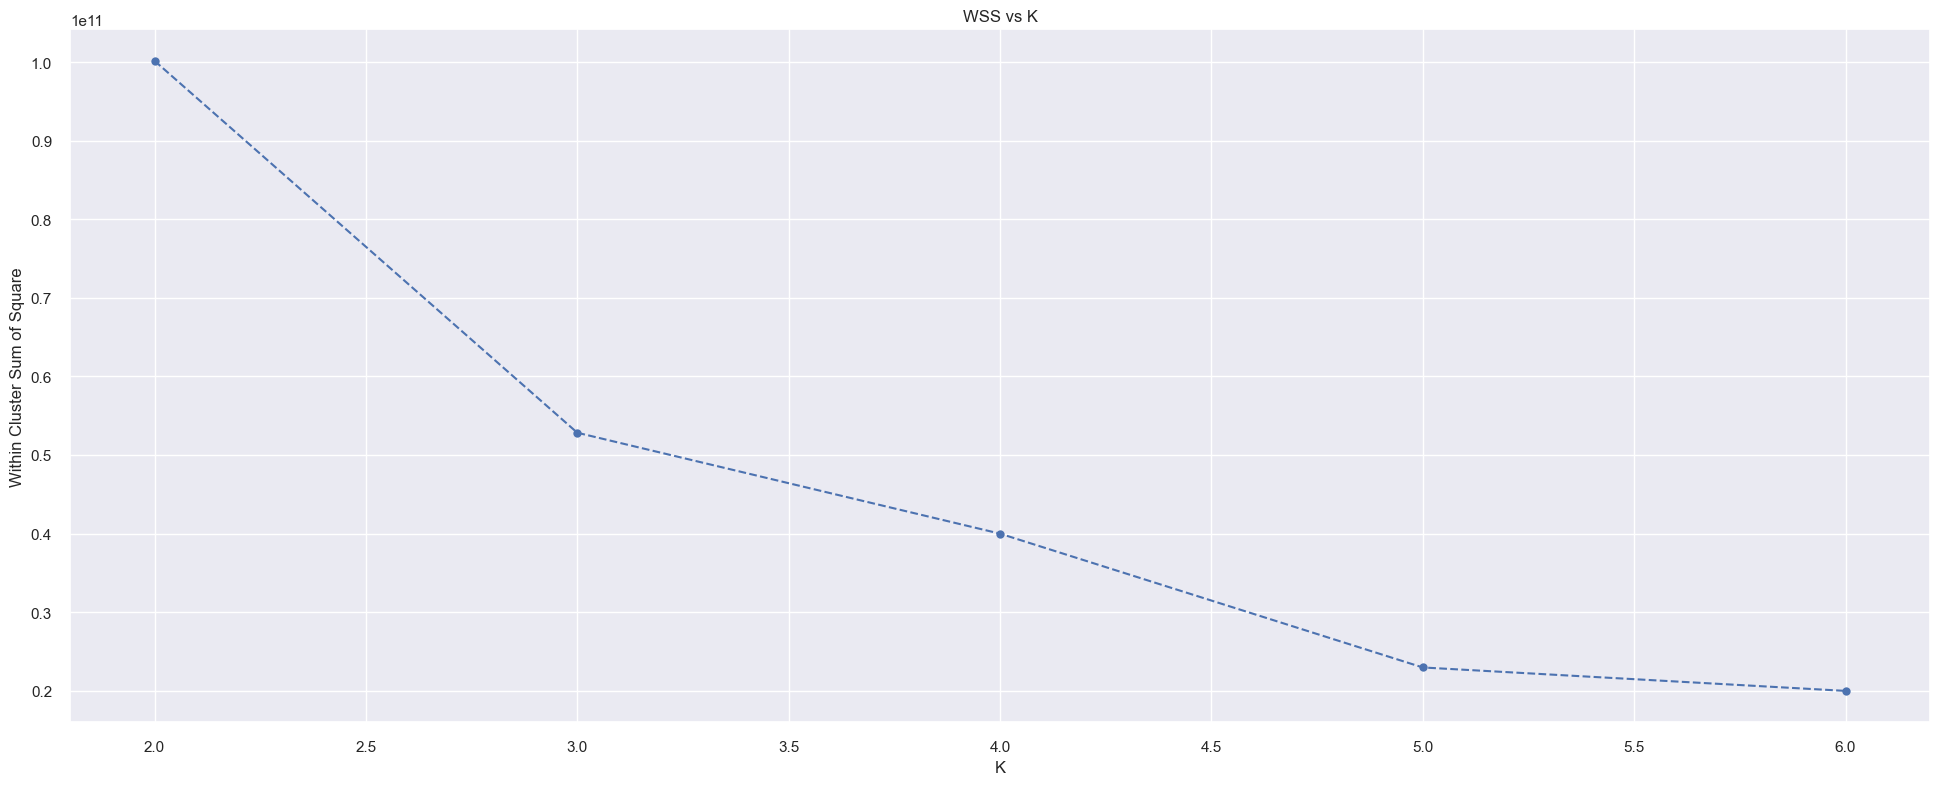

In [80]:
wss = []

for k in clusters:
    # Model Definition
    kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )
    
    # Model Training
    kmeans.fit( X )
    
    # Validation
    wss.append( kmeans.inertia_ )
    
# plot WSS - Elbow Method
plt.plot( clusters, wss, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Within Cluster Sum of Square' );
plt.title( 'WSS vs K' );

## 7.2. Sillhouette Score

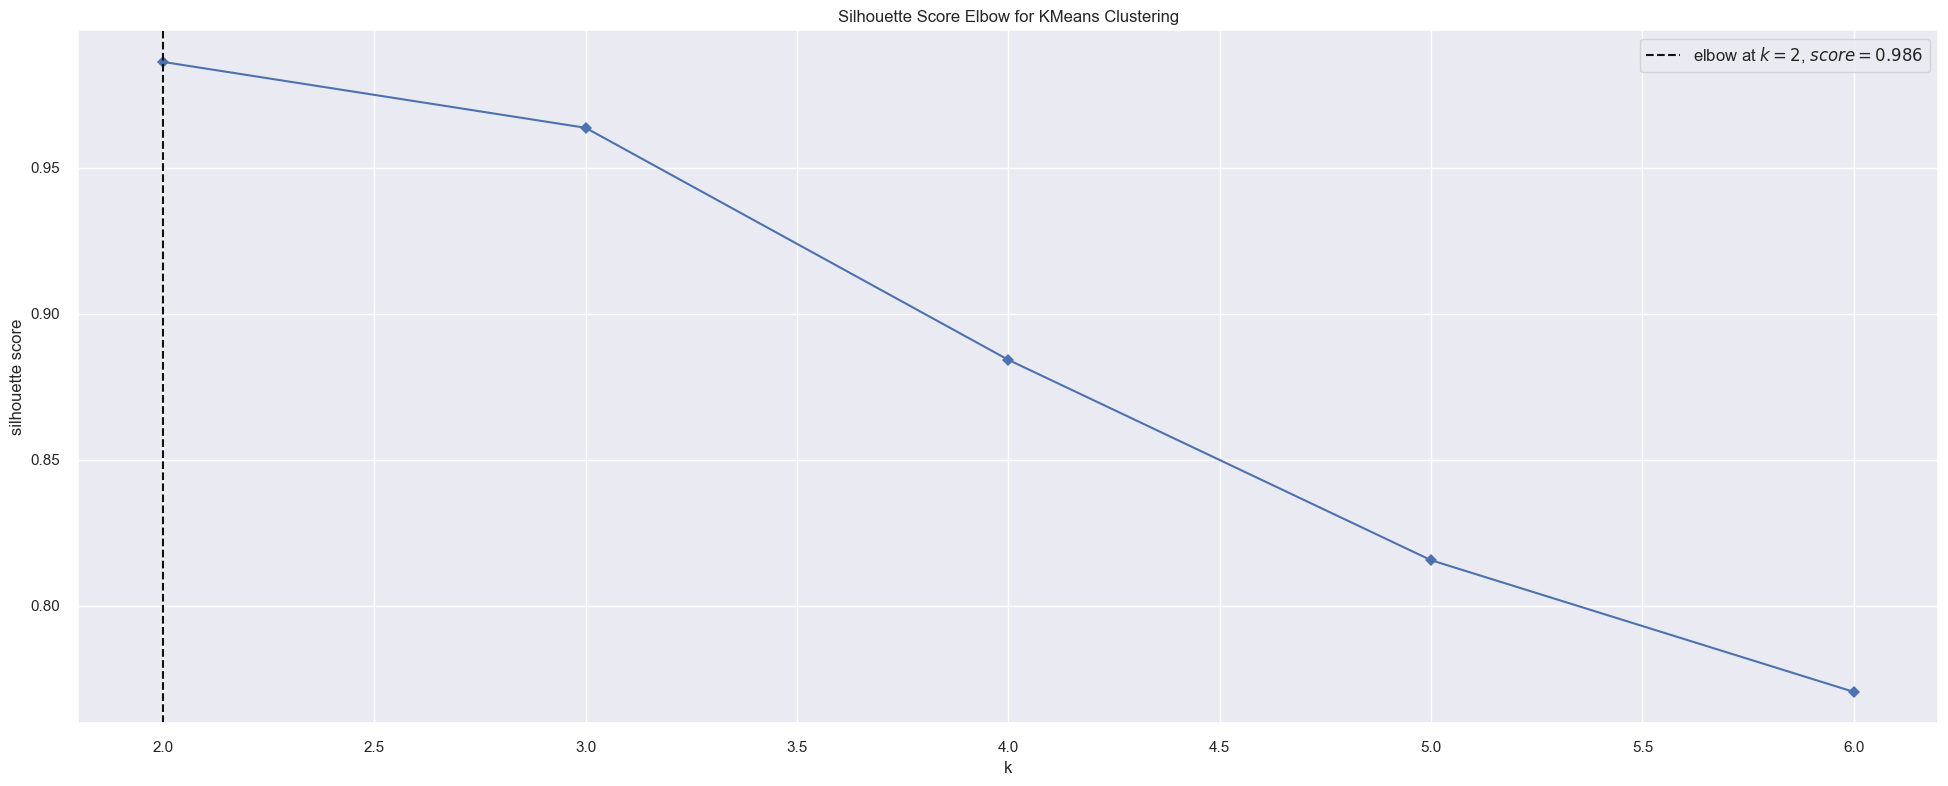

In [81]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show();

# 8.0 Model Training

## 8.1. K-Means

In [82]:
# Model Definition
k = 3
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# Model Training
kmeans.fit( X )

# Clustering
labels = kmeans.labels_

### 8.1.1. Cluster Validation

In [83]:
# WSS (Within-cluster sum of square)
print('WSS Value: {}'.format(kmeans.inertia_) )

# SS (Silhouette Score)
print('SS Value: {}'.format(m.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS Value: 52830436382.66514
SS Value: 0.9494677108004962


# 9.0 Cluster Analyses

In [85]:
df9 = df6.copy()
df9['clusters'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,clusters
0,17850,5288.63,301,35,0
1,13047,3079.10,31,18,0
2,12583,7187.34,2,18,0
3,13748,948.25,95,5,0
4,15100,635.10,329,6,0


## 9.1. Visualization Inspection

In [88]:
fig = px.scatter_3d( df9, x='recency_days', y='invoice_no', z='gross_revenue', color='clusters' )
fig.show()

## 9.2. Cluster Profile

In [108]:
# Numbers of Customers
df_cluster = df9[['clusters', 'customer_id']].groupby('clusters').count().reset_index()
df_cluster['perc_customer'] = 100 * ( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross Revenue
df_avg_gross_revenue = df9[['clusters', 'gross_revenue']].groupby( 'clusters' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, on='clusters', how='inner' )

# Avg Recency Days
df_avg_recency_days = df9[['clusters', 'recency_days']].groupby( 'clusters' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, on='clusters', how='inner' )

# Avg Invoice_no
df_avg_invoice_no = df9[['clusters', 'invoice_no']].groupby( 'clusters' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_no, on='clusters', how='inner' )

In [109]:
df_cluster

,clusters,customer_id,perc_customer,gross_revenue,recency_days,invoice_no
0,0,4335,99.153705,1372.577826,91.723414,4.614533
1,1,6,0.137237,182181.981667,6.666667,89.000000
2,2,31,0.709058,40543.517742,12.806452,53.290323


# 10.0 Deploy to Production